In [2]:
"""
================================================================================
SECCIÓN 3: APRENDIZAJE NO SUPERVISADO (TAREAS 9, 10, 11, 12)
================================================================================

OBJETIVO: Aplicar técnicas de clustering y reducción dimensional para descubrir
patrones ocultos en los datos y evaluar su relación con la variable objetivo.
================================================================================
"""

# ============================================
# CONFIGURACIÓN INICIAL E IMPORTACIONES
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import warnings
import pickle
import json
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage

# Scikit-learn imports
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (silhouette_score, silhouette_samples, 
                             calinski_harabasz_score, davies_bouldin_score,
                             adjusted_rand_score, normalized_mutual_info_score)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Imports opcionales (instalar si es necesario)
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("⚠️  UMAP no disponible. Instalar con: pip install umap-learn")

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RANDOM_STATE = 42
TARGET_COLUMN = 'DESEMP_INGLES'
np.random.seed(RANDOM_STATE)

print("="*80)
print("SECCIÓN 3: APRENDIZAJE NO SUPERVISADO")
print("="*80)
print(f"📌 Random State: {RANDOM_STATE}")
print(f"🎯 Variable Objetivo: {TARGET_COLUMN}\n")


# ============================================
# CARGAR DATOS PREPROCESADOS
# ============================================

print("="*80)
print("CARGANDO DATOS PREPROCESADOS DE SECCIÓN 2")
print("="*80 + "\n")

try:
    # Cargar objetos preprocesados
    with open('train_test_split.pkl', 'rb') as f:
        train_test_data = pickle.load(f)
    
    X_train = train_test_data['X_train']
    X_test = train_test_data['X_test']
    y_train = train_test_data['y_train']
    y_test = train_test_data['y_test']
    y_train_original = train_test_data['y_train_original']
    y_test_original = train_test_data['y_test_original']
    
    print(f"✅ X_train: {X_train.shape}")
    print(f"✅ X_test: {X_test.shape}")
    print(f"✅ y_train: {y_train.shape}")
    print(f"✅ y_test: {y_test.shape}")
    
    # Cargar objetos de preprocesamiento
    with open('preprocessing_objects.pkl', 'rb') as f:
        preprocessing_objects = pickle.load(f)
    
    le_target = preprocessing_objects['label_encoder_target']
    target_mapping = preprocessing_objects['target_mapping']
    
    print(f"\n✅ Mapeo de clases: {target_mapping}")
    
    # Cargar PCA si existe
    try:
        with open('pca_models.pkl', 'rb') as f:
            pca_objects = pickle.load(f)
        X_train_pca = pca_objects['X_train_pca']
        X_test_pca = pca_objects['X_test_pca']
        optimal_n_components = pca_objects['optimal_n_components']
        print(f"✅ PCA cargado: {optimal_n_components} componentes")
    except:
        print("⚠️  PCA no encontrado, se usará dataset completo")
        X_train_pca = X_train.values
        X_test_pca = X_test.values
        
except Exception as e:
    print(f"❌ Error cargando datos: {e}")
    print("⚠️  Ejecuta primero la Sección 2 (Preprocesamiento)")
    raise

# Configurar mapeo de colores para visualizaciones
color_map_classes = {
    'A-': '#d62728',   # Rojo
    'A1': '#ff7f0e',   # Naranja
    'A2': '#2ca02c',   # Verde
    'B1': '#1f77b4',   # Azul
    'B+': '#9467bd'    # Púrpura
}

print("\n✅ Datos cargados correctamente")



⚠️  UMAP no disponible. Instalar con: pip install umap-learn
SECCIÓN 3: APRENDIZAJE NO SUPERVISADO
📌 Random State: 42
🎯 Variable Objetivo: DESEMP_INGLES

CARGANDO DATOS PREPROCESADOS DE SECCIÓN 2

✅ X_train: (152306, 20)
✅ X_test: (65275, 20)
✅ y_train: (152306,)
✅ y_test: (65275,)

✅ Mapeo de clases: {'A-': 0, 'A1': 1, 'A2': 2, 'B+': 3, 'B1': 4}
✅ PCA cargado: 8 componentes

✅ Datos cargados correctamente


In [3]:

# ============================================
# TAREA 9: APLICAR CLUSTERING
# ============================================

print("\n\n" + "="*80)
print("TAREA 9: APLICACIÓN DE MÉTODOS DE CLUSTERING")
print("="*80 + "\n")

"""
Implementaremos tres algoritmos de clustering:
1. K-Means: Clustering particional basado en centroides
2. DBSCAN: Clustering basado en densidad (identifica outliers)
3. Jerárquico Aglomerativo: Clustering jerárquico bottom-up

Usaremos el dataset PCA para reducir dimensionalidad y mejorar performance.
"""

# Preparar datos para clustering
X_clustering = X_train_pca if X_train_pca.shape[1] < 20 else X_train.values
print(f"📊 Dataset para clustering: {X_clustering.shape}")
print(f"   Tipo: {'PCA' if X_clustering.shape[1] < X_train.shape[1] else 'Original'}\n")

# ===================
# 9.1: K-MEANS CLUSTERING
# ===================

print("9.1 K-MEANS CLUSTERING")
print("-" * 80 + "\n")

# Probar con k=5 (número de clases reales)
n_clusters_kmeans = 5

print(f"Configuración: n_clusters = {n_clusters_kmeans}")
print("Entrenando K-Means...\n")

kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=RANDOM_STATE, 
                n_init=10, max_iter=300)
kmeans_labels = kmeans.fit_predict(X_clustering)

# Métricas
kmeans_silhouette = silhouette_score(X_clustering, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(X_clustering, kmeans_labels)
kmeans_davies = davies_bouldin_score(X_clustering, kmeans_labels)
kmeans_inertia = kmeans.inertia_

print(f"✅ K-Means completado")
print(f"\nMétricas:")
print(f"   • Silhouette Score:        {kmeans_silhouette:.4f}  (rango [-1, 1], mejor: cercano a 1)")
print(f"   • Calinski-Harabasz:       {kmeans_calinski:.2f}   (mejor: más alto)")
print(f"   • Davies-Bouldin:          {kmeans_davies:.4f}  (mejor: más bajo)")
print(f"   • Inertia (suma cuadrados):{kmeans_inertia:.2f}")

# Distribución de clusters
print(f"\nDistribución de clusters:")
unique, counts = np.unique(kmeans_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    pct = count / len(kmeans_labels) * 100
    print(f"   Cluster {cluster}: {count:6,} obs ({pct:5.2f}%)")





TAREA 9: APLICACIÓN DE MÉTODOS DE CLUSTERING

📊 Dataset para clustering: (152306, 8)
   Tipo: PCA

9.1 K-MEANS CLUSTERING
--------------------------------------------------------------------------------

Configuración: n_clusters = 5
Entrenando K-Means...

✅ K-Means completado

Métricas:
   • Silhouette Score:        0.1666  (rango [-1, 1], mejor: cercano a 1)
   • Calinski-Harabasz:       80745.31   (mejor: más alto)
   • Davies-Bouldin:          1.6649  (mejor: más bajo)
   • Inertia (suma cuadrados):291957.46

Distribución de clusters:
   Cluster 0: 39,272 obs (25.78%)
   Cluster 1: 38,603 obs (25.35%)
   Cluster 2: 31,776 obs (20.86%)
   Cluster 3: 25,854 obs (16.98%)
   Cluster 4: 16,801 obs (11.03%)


In [4]:

# ===================
# 9.2: DBSCAN CLUSTERING
# ===================

print("\n\n9.2 DBSCAN (DENSITY-BASED CLUSTERING)")
print("-" * 80 + "\n")

# Configuración DBSCAN
# Regla heurística: eps ≈ distancia al k-ésimo vecino más cercano
# min_samples ≈ 2 * dimensiones
from sklearn.neighbors import NearestNeighbors

k = min(10, X_clustering.shape[1] * 2)
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_clustering)
distances, indices = neighbors_fit.kneighbors(X_clustering)
distances = np.sort(distances[:, k-1], axis=0)

# Estimar eps del "codo" en la curva de distancias
eps_estimate = np.percentile(distances, 90)  # Percentil 90
min_samples_estimate = k

print(f"Configuración (estimada automáticamente):")
print(f"   eps = {eps_estimate:.4f}")
print(f"   min_samples = {min_samples_estimate}")
print("\nEntrenando DBSCAN...\n")

dbscan = DBSCAN(eps=eps_estimate, min_samples=min_samples_estimate)
dbscan_labels = dbscan.fit_predict(X_clustering)

# Métricas (excluyendo noise points = -1)
mask_not_noise = dbscan_labels != -1
n_noise = np.sum(~mask_not_noise)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

if n_clusters_dbscan > 1 and mask_not_noise.sum() > 0:
    dbscan_silhouette = silhouette_score(X_clustering[mask_not_noise], 
                                         dbscan_labels[mask_not_noise])
    dbscan_calinski = calinski_harabasz_score(X_clustering[mask_not_noise], 
                                               dbscan_labels[mask_not_noise])
    dbscan_davies = davies_bouldin_score(X_clustering[mask_not_noise], 
                                         dbscan_labels[mask_not_noise])
else:
    dbscan_silhouette = dbscan_calinski = dbscan_davies = np.nan

print(f"✅ DBSCAN completado")
print(f"\nResultados:")
print(f"   • Clusters encontrados:    {n_clusters_dbscan}")
print(f"   • Noise points:            {n_noise:,} ({n_noise/len(dbscan_labels)*100:.2f}%)")

if not np.isnan(dbscan_silhouette):
    print(f"\nMétricas (sin noise):")
    print(f"   • Silhouette Score:        {dbscan_silhouette:.4f}")
    print(f"   • Calinski-Harabasz:       {dbscan_calinski:.2f}")
    print(f"   • Davies-Bouldin:          {dbscan_davies:.4f}")

# Distribución de clusters
print(f"\nDistribución de clusters:")
unique_db, counts_db = np.unique(dbscan_labels, return_counts=True)
for cluster, count in zip(unique_db, counts_db):
    pct = count / len(dbscan_labels) * 100
    label = "Noise" if cluster == -1 else f"Cluster {cluster}"
    print(f"   {label:12s}: {count:6,} obs ({pct:5.2f}%)")




9.2 DBSCAN (DENSITY-BASED CLUSTERING)
--------------------------------------------------------------------------------

Configuración (estimada automáticamente):
   eps = 0.5739
   min_samples = 10

Entrenando DBSCAN...

✅ DBSCAN completado

Resultados:
   • Clusters encontrados:    34
   • Noise points:            5,728 (3.76%)

Métricas (sin noise):
   • Silhouette Score:        -0.2835
   • Calinski-Harabasz:       1266.54
   • Davies-Bouldin:          3.1995

Distribución de clusters:
   Noise       :  5,728 obs ( 3.76%)
   Cluster 0   : 21,053 obs (13.82%)
   Cluster 1   : 13,523 obs ( 8.88%)
   Cluster 2   :  4,904 obs ( 3.22%)
   Cluster 3   :  8,140 obs ( 5.34%)
   Cluster 4   : 36,698 obs (24.09%)
   Cluster 5   : 10,461 obs ( 6.87%)
   Cluster 6   :  9,982 obs ( 6.55%)
   Cluster 7   :  2,503 obs ( 1.64%)
   Cluster 8   :  6,208 obs ( 4.08%)
   Cluster 9   :  3,218 obs ( 2.11%)
   Cluster 10  :  3,943 obs ( 2.59%)
   Cluster 11  :  7,784 obs ( 5.11%)
   Cluster 12  :  8,870

In [5]:

# ===================
# 9.3: CLUSTERING JERÁRQUICO
# ===================

print("\n\n9.3 CLUSTERING JERÁRQUICO AGLOMERATIVO")
print("-" * 80 + "\n")

# Usar muestra si dataset muy grande (jerárquico es O(n³))
if len(X_clustering) > 10000:
    sample_indices = np.random.choice(len(X_clustering), 10000, replace=False)
    X_hierarchical = X_clustering[sample_indices]
    print(f"⚠️  Usando muestra de 10,000 obs para eficiencia")
else:
    X_hierarchical = X_clustering
    sample_indices = np.arange(len(X_clustering))

n_clusters_hier = 5

print(f"Configuración:")
print(f"   n_clusters = {n_clusters_hier}")
print(f"   linkage = 'ward'")
print(f"   n_samples = {len(X_hierarchical):,}")
print("\nEntrenando Clustering Jerárquico...\n")

hierarchical = AgglomerativeClustering(n_clusters=n_clusters_hier, linkage='ward')
hierarchical_labels_sample = hierarchical.fit_predict(X_hierarchical)

# Para dataset completo, predecir usando el modelo entrenado en la muestra
# (Nota: AgglomerativeClustering no tiene predict, usamos aproximación)
# Solución: entrenar en todo el dataset si es posible, o usar muestra
if len(X_clustering) > len(X_hierarchical):
    # Predecir usando k-nearest neighbors
    from sklearn.neighbors import KNeighborsClassifier
    knn_proxy = KNeighborsClassifier(n_neighbors=5)
    knn_proxy.fit(X_hierarchical, hierarchical_labels_sample)
    hierarchical_labels = knn_proxy.predict(X_clustering)
else:
    hierarchical_labels = hierarchical_labels_sample

# Métricas
hier_silhouette = silhouette_score(X_clustering, hierarchical_labels)
hier_calinski = calinski_harabasz_score(X_clustering, hierarchical_labels)
hier_davies = davies_bouldin_score(X_clustering, hierarchical_labels)

print(f"✅ Clustering Jerárquico completado")
print(f"\nMétricas:")
print(f"   • Silhouette Score:        {hier_silhouette:.4f}")
print(f"   • Calinski-Harabasz:       {hier_calinski:.2f}")
print(f"   • Davies-Bouldin:          {hier_davies:.4f}")

# Distribución de clusters
print(f"\nDistribución de clusters:")
unique_hier, counts_hier = np.unique(hierarchical_labels, return_counts=True)
for cluster, count in zip(unique_hier, counts_hier):
    pct = count / len(hierarchical_labels) * 100
    print(f"   Cluster {cluster}: {count:6,} obs ({pct:5.2f}%)")

# Dendrograma (solo para muestra pequeña)
if len(X_hierarchical) <= 1000:
    print("\n📊 Generando dendrograma...")
    
    linkage_matrix = linkage(X_hierarchical, method='ward')
    
    plt.figure(figsize=(14, 6))
    dendrogram(linkage_matrix, truncate_mode='lastp', p=30, 
              leaf_rotation=90, leaf_font_size=10,
              show_contracted=True)
    plt.title('Dendrograma - Clustering Jerárquico (Ward Linkage)', 
             fontsize=14, fontweight='bold')
    plt.xlabel('Cluster Index o (Cluster Size)', fontsize=11)
    plt.ylabel('Distancia', fontsize=11)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()





9.3 CLUSTERING JERÁRQUICO AGLOMERATIVO
--------------------------------------------------------------------------------

⚠️  Usando muestra de 10,000 obs para eficiencia
Configuración:
   n_clusters = 5
   linkage = 'ward'
   n_samples = 10,000

Entrenando Clustering Jerárquico...

✅ Clustering Jerárquico completado

Métricas:
   • Silhouette Score:        0.1336
   • Calinski-Harabasz:       69372.75
   • Davies-Bouldin:          1.9158

Distribución de clusters:
   Cluster 0: 43,466 obs (28.54%)
   Cluster 1: 26,453 obs (17.37%)
   Cluster 2: 43,808 obs (28.76%)
   Cluster 3: 15,902 obs (10.44%)
   Cluster 4: 22,677 obs (14.89%)




9.4 COMPARACIÓN DE ALGORITMOS
--------------------------------------------------------------------------------

Tabla comparativa de métricas:

 Algoritmo  N_Clusters  Silhouette  Calinski-Harabasz  Davies-Bouldin
   K-Means           5    0.166645       80745.314752        1.664926
    DBSCAN          34   -0.283522        1266.535235        3.199538
Jerárquico           5    0.133633       69372.748977        1.915827


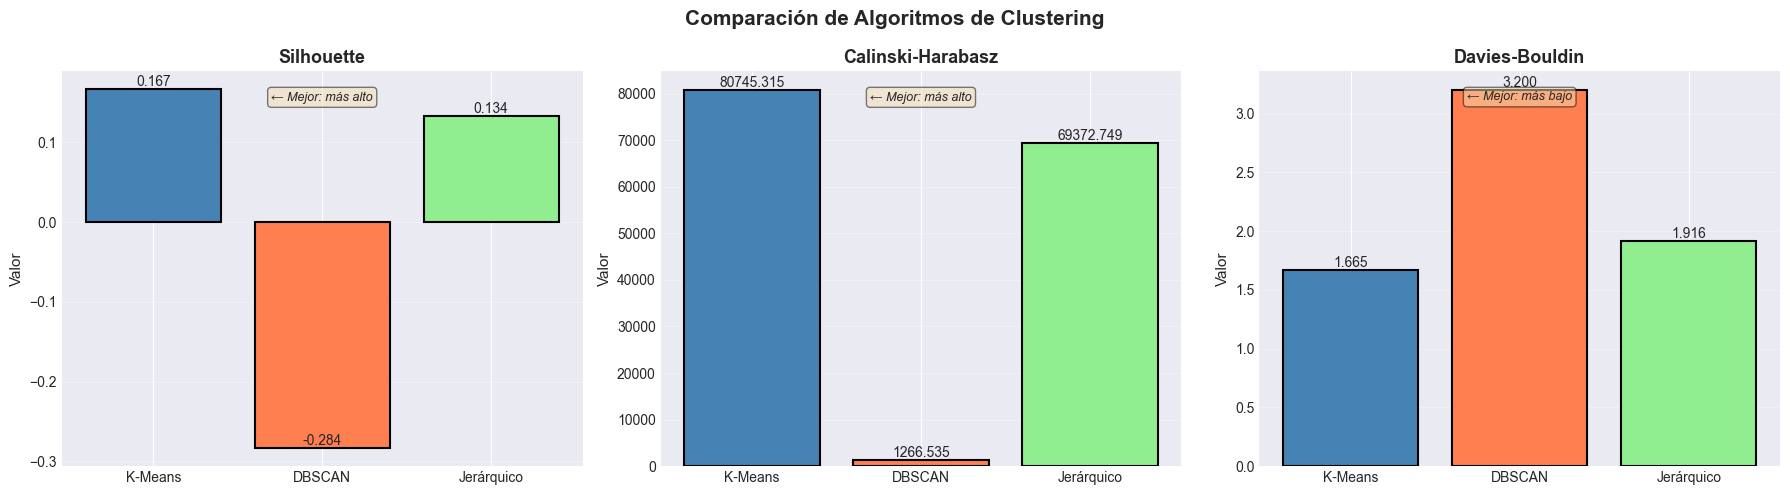


🏆 Análisis de mejor algoritmo:
   • Mejor Silhouette: K-Means
   • Mejor Calinski-Harabasz: K-Means
   • Mejor Davies-Bouldin: K-Means

💾 Resultados guardados: clustering_results.pkl

✅ TAREA 9 COMPLETADA

INTERPRETACIÓN:
Los tres algoritmos producen resultados diferentes:

• K-MEANS: Asume clusters esféricos, funciona bien con datos bien separados.
  Bueno para cuando conocemos el número de clusters a priori.

• DBSCAN: Identifica clusters de forma arbitraria y detecta outliers (noise points).
  Útil cuando hay ruido o clusters de densidad variable.

• JERÁRQUICO: Crea una jerarquía de clusters, útil para entender estructura multinivel.
  Más costoso computacionalmente pero muy interpretable.

La métrica Silhouette más alta sugiere clusters mejor definidos y separados.



In [6]:

# ===================
# 9.4: COMPARACIÓN DE ALGORITMOS
# ===================

print("\n\n9.4 COMPARACIÓN DE ALGORITMOS")
print("-" * 80 + "\n")

comparison_df = pd.DataFrame({
    'Algoritmo': ['K-Means', 'DBSCAN', 'Jerárquico'],
    'N_Clusters': [n_clusters_kmeans, n_clusters_dbscan, n_clusters_hier],
    'Silhouette': [kmeans_silhouette, dbscan_silhouette if not np.isnan(dbscan_silhouette) else 0, 
                   hier_silhouette],
    'Calinski-Harabasz': [kmeans_calinski, dbscan_calinski if not np.isnan(dbscan_calinski) else 0, 
                          hier_calinski],
    'Davies-Bouldin': [kmeans_davies, dbscan_davies if not np.isnan(dbscan_davies) else 0, 
                       hier_davies]
})

print("Tabla comparativa de métricas:\n")
print(comparison_df.to_string(index=False))

# Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']
colors_bars = ['steelblue', 'coral', 'lightgreen']

for idx, metric in enumerate(metrics):
    values = comparison_df[metric].values
    bars = axes[idx].bar(comparison_df['Algoritmo'], values, 
                        color=colors_bars, edgecolor='black', linewidth=1.5)
    
    axes[idx].set_title(f'{metric}', fontsize=13, fontweight='bold')
    axes[idx].set_ylabel('Valor', fontsize=11)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Anotar valores
    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{val:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Indicar mejor dirección
    if metric == 'Davies-Bouldin':
        axes[idx].text(0.5, 0.95, '← Mejor: más bajo', transform=axes[idx].transAxes,
                      ha='center', va='top', fontsize=9, style='italic',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    else:
        axes[idx].text(0.5, 0.95, '← Mejor: más alto', transform=axes[idx].transAxes,
                      ha='center', va='top', fontsize=9, style='italic',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Comparación de Algoritmos de Clustering', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Determinar mejor algoritmo
print(f"\n🏆 Análisis de mejor algoritmo:")
print(f"   • Mejor Silhouette: {comparison_df.loc[comparison_df['Silhouette'].idxmax(), 'Algoritmo']}")
print(f"   • Mejor Calinski-Harabasz: {comparison_df.loc[comparison_df['Calinski-Harabasz'].idxmax(), 'Algoritmo']}")
print(f"   • Mejor Davies-Bouldin: {comparison_df.loc[comparison_df['Davies-Bouldin'].idxmin(), 'Algoritmo']}")

# Guardar resultados
clustering_results = {
    'kmeans_model': kmeans,
    'kmeans_labels': kmeans_labels,
    'dbscan_model': dbscan,
    'dbscan_labels': dbscan_labels,
    'hierarchical_labels': hierarchical_labels,
    'comparison_df': comparison_df,
    'X_clustering': X_clustering
}

with open('clustering_results.pkl', 'wb') as f:
    pickle.dump(clustering_results, f)

print("\n💾 Resultados guardados: clustering_results.pkl")

print("\n" + "="*80)
print("✅ TAREA 9 COMPLETADA")
print("="*80)

print("""
INTERPRETACIÓN:
Los tres algoritmos producen resultados diferentes:

• K-MEANS: Asume clusters esféricos, funciona bien con datos bien separados.
  Bueno para cuando conocemos el número de clusters a priori.

• DBSCAN: Identifica clusters de forma arbitraria y detecta outliers (noise points).
  Útil cuando hay ruido o clusters de densidad variable.

• JERÁRQUICO: Crea una jerarquía de clusters, útil para entender estructura multinivel.
  Más costoso computacionalmente pero muy interpretable.

La métrica Silhouette más alta sugiere clusters mejor definidos y separados.
""")


In [20]:
import os
# ============================================
# 💾 CHECKPOINT COMPLETO - TAREA 9
# ============================================

print("\n" + "="*80)
print("💾 GUARDANDO CHECKPOINT COMPLETO - TAREA 9")
print("="*80 + "\n")

checkpoint_tarea9 = {
    # Datos de entrenamiento
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'y_train_original': y_train_original,
    'y_test_original': y_test_original,
    
    # Datos de clustering
    'X_clustering': X_clustering,
    'X_train_pca': X_train_pca,
    'X_test_pca': X_test_pca,
    
    # Modelos de clustering
    'kmeans': kmeans,
    'kmeans_labels': kmeans_labels,
    'dbscan': dbscan,
    'dbscan_labels': dbscan_labels,
    'hierarchical_labels': hierarchical_labels,
    
    # Métricas
    'kmeans_silhouette': kmeans_silhouette,
    'kmeans_calinski': kmeans_calinski,
    'kmeans_davies': kmeans_davies,
    'dbscan_silhouette': dbscan_silhouette,
    'hier_silhouette': hier_silhouette,
    
    # Parámetros
    'n_clusters_kmeans': n_clusters_kmeans,
    'n_clusters_dbscan': n_clusters_dbscan,
    'n_clusters_hier': n_clusters_hier,
    
    # Objetos auxiliares
    'le_target': le_target,
    'target_mapping': target_mapping,
    'color_map_classes': color_map_classes
}

with open('checkpoint_completo_tarea9.pkl', 'wb') as f:
    pickle.dump(checkpoint_tarea9, f)

print("✅ Checkpoint guardado: checkpoint_completo_tarea9.pkl")
print(f"   Tamaño: {os.path.getsize('checkpoint_completo_tarea9.pkl') / 1024**2:.2f} MB")


💾 GUARDANDO CHECKPOINT COMPLETO - TAREA 9

✅ Checkpoint guardado: checkpoint_completo_tarea9.pkl
   Tamaño: 49.67 MB




TAREA 10: DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS

10.1 MÉTODO DEL CODO (ELBOW METHOD)
--------------------------------------------------------------------------------

Probando k = [2, 3, 4, 5, 6, 7, 8, 9, 10]

   Evaluando k = 2... ✓
   Evaluando k = 3... ✓
   Evaluando k = 4... ✓
   Evaluando k = 5... ✓
   Evaluando k = 6... ✓
   Evaluando k = 7... ✓
   Evaluando k = 8... ✓
   Evaluando k = 9... ✓
   Evaluando k = 10... ✓

✅ Evaluación completada

Resultados por k:

 k       Inertia  Silhouette  Calinski-Harabasz  Davies-Bouldin
 2 464486.490142    0.380654      146444.956577        0.972550
 3 355933.805003    0.277092      118777.768286        1.191166
 4 313145.414680    0.211708       96941.646104        1.421320
 5 291957.460725    0.166645       80745.314752        1.664926
 6 276457.436737    0.163858       69925.640343        1.729135
 7 262940.529078    0.155845       62571.290900        1.791170
 8 252842.488716    0.153257       56643.022311        1.737393
 9 24442

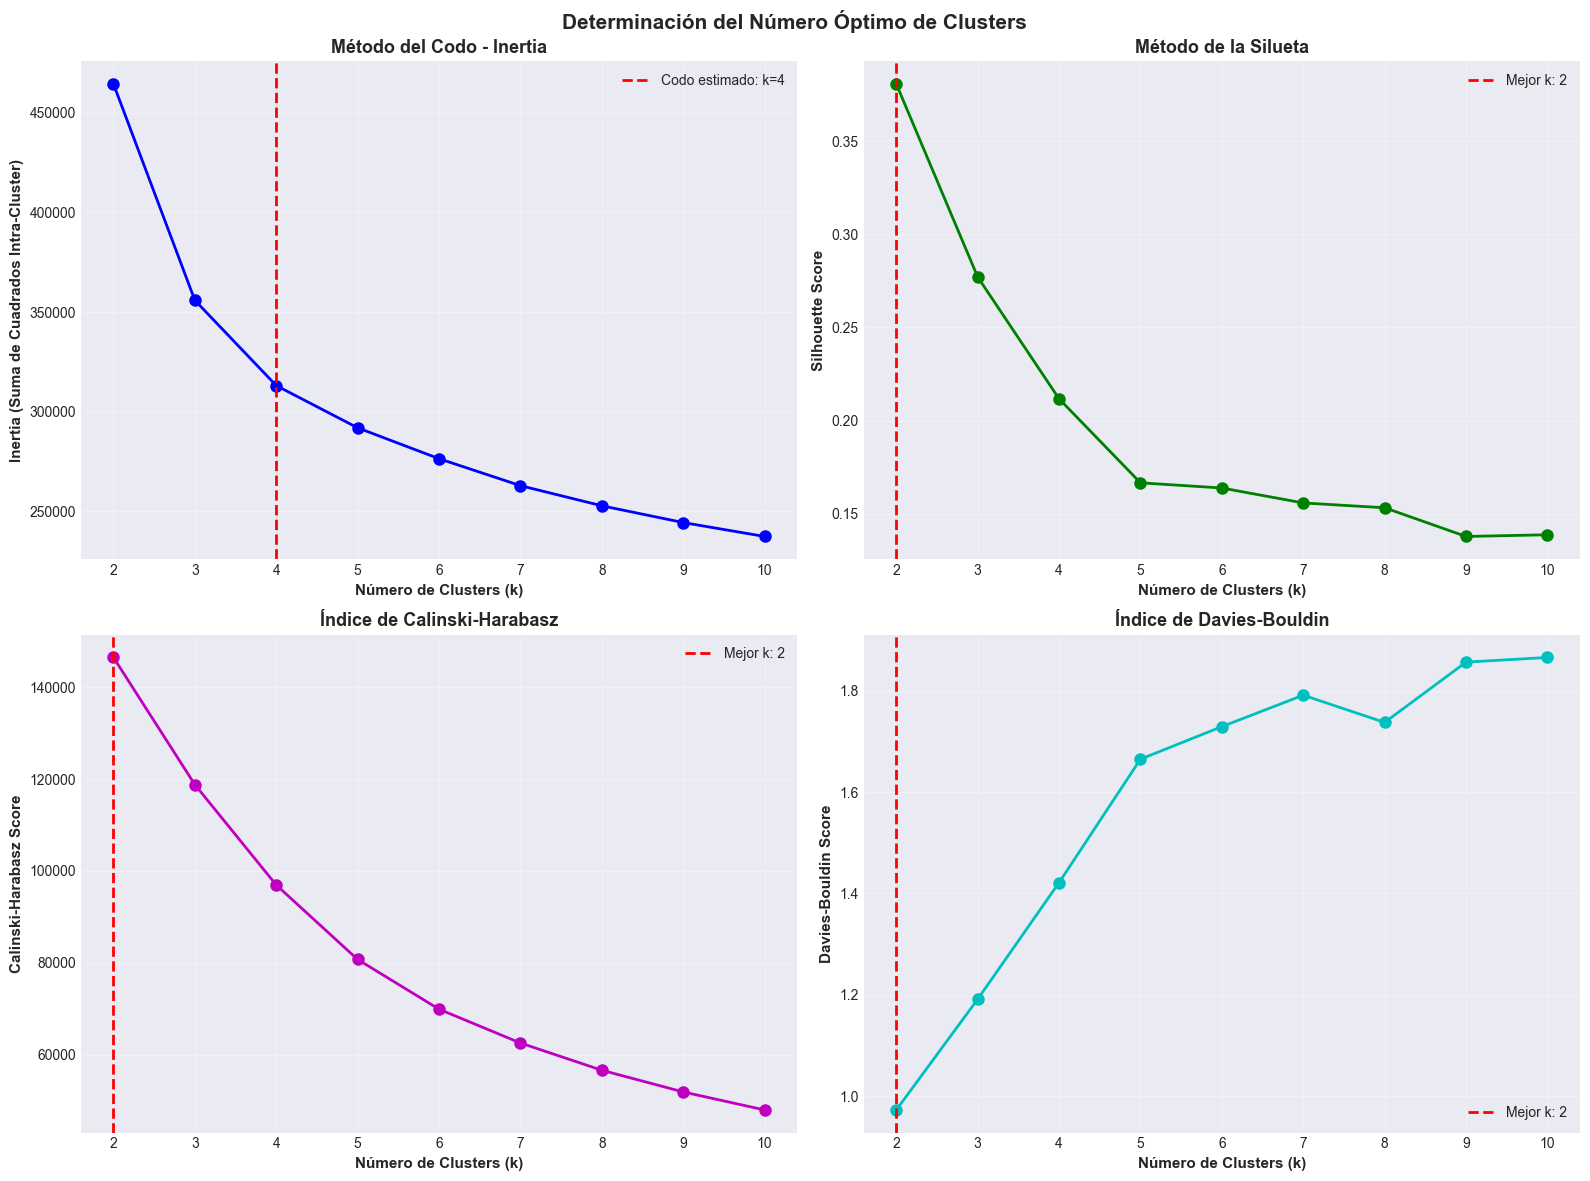


🎯 NÚMERO ÓPTIMO DE CLUSTERS:

   • Método del Codo (Inertia):    k = 4
   • Método de la Silueta:         k = 2
   • Calinski-Harabasz:            k = 2
   • Davies-Bouldin:               k = 2

✅ K ÓPTIMO RECOMENDADO (por consenso): k = 2


In [7]:


# ============================================
# TAREA 10: DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS
# ============================================

print("\n\n" + "="*80)
print("TAREA 10: DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS")
print("="*80 + "\n")

"""
Aplicaremos dos métodos principales:
1. Método del Codo (Elbow Method): Analiza la inercia/distorsión
2. Método de la Silueta (Silhouette Method): Analiza la cohesión y separación
"""

# ===================
# 10.1: MÉTODO DEL CODO (ELBOW METHOD)
# ===================

print("10.1 MÉTODO DEL CODO (ELBOW METHOD)")
print("-" * 80 + "\n")

k_range = range(2, 11)
print(f"Probando k = {list(k_range)}\n")

inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

for k in k_range:
    print(f"   Evaluando k = {k}...", end=' ')
    
    # K-Means
    kmeans_k = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels_k = kmeans_k.fit_predict(X_clustering)
    
    # Métricas
    inertias.append(kmeans_k.inertia_)
    silhouette_scores.append(silhouette_score(X_clustering, labels_k))
    calinski_scores.append(calinski_harabasz_score(X_clustering, labels_k))
    davies_bouldin_scores.append(davies_bouldin_score(X_clustering, labels_k))
    
    print("✓")

print("\n✅ Evaluación completada\n")

# Resultados
results_df = pd.DataFrame({
    'k': list(k_range),
    'Inertia': inertias,
    'Silhouette': silhouette_scores,
    'Calinski-Harabasz': calinski_scores,
    'Davies-Bouldin': davies_bouldin_scores
})

print("Resultados por k:\n")
print(results_df.to_string(index=False))

# Visualización del método del codo
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Inertia (método del codo clásico)
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Número de Clusters (k)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Inertia (Suma de Cuadrados Intra-Cluster)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Método del Codo - Inertia', fontsize=13, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xticks(k_range)

# Marcar el "codo" estimado
# Calculamos la segunda derivada para encontrar el punto de máxima curvatura
inertia_diff = np.diff(inertias)
inertia_diff2 = np.diff(inertia_diff)
elbow_k = list(k_range)[np.argmax(inertia_diff2) + 2]  # +2 por las dos diferencias
axes[0, 0].axvline(x=elbow_k, color='red', linestyle='--', linewidth=2, 
                  label=f'Codo estimado: k={elbow_k}')
axes[0, 0].legend()

# Plot 2: Silhouette Score
axes[0, 1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Número de Clusters (k)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Método de la Silueta', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xticks(k_range)

# Marcar el máximo
best_silhouette_k = list(k_range)[np.argmax(silhouette_scores)]
axes[0, 1].axvline(x=best_silhouette_k, color='red', linestyle='--', linewidth=2,
                  label=f'Mejor k: {best_silhouette_k}')
axes[0, 1].legend()

# Plot 3: Calinski-Harabasz Score
axes[1, 0].plot(k_range, calinski_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Número de Clusters (k)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Índice de Calinski-Harabasz', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xticks(k_range)

best_calinski_k = list(k_range)[np.argmax(calinski_scores)]
axes[1, 0].axvline(x=best_calinski_k, color='red', linestyle='--', linewidth=2,
                  label=f'Mejor k: {best_calinski_k}')
axes[1, 0].legend()

# Plot 4: Davies-Bouldin Score
axes[1, 1].plot(k_range, davies_bouldin_scores, 'co-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Número de Clusters (k)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Davies-Bouldin Score', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Índice de Davies-Bouldin', fontsize=13, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xticks(k_range)

best_davies_k = list(k_range)[np.argmin(davies_bouldin_scores)]
axes[1, 1].axvline(x=best_davies_k, color='red', linestyle='--', linewidth=2,
                  label=f'Mejor k: {best_davies_k}')
axes[1, 1].legend()

plt.suptitle('Determinación del Número Óptimo de Clusters', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Resumen de k óptimo
print(f"\n🎯 NÚMERO ÓPTIMO DE CLUSTERS:\n")
print(f"   • Método del Codo (Inertia):    k = {elbow_k}")
print(f"   • Método de la Silueta:         k = {best_silhouette_k}")
print(f"   • Calinski-Harabasz:            k = {best_calinski_k}")
print(f"   • Davies-Bouldin:               k = {best_davies_k}")

# Determinar k óptimo por votación
from collections import Counter
optimal_k_votes = [elbow_k, best_silhouette_k, best_calinski_k, best_davies_k]
optimal_k = Counter(optimal_k_votes).most_common(1)[0][0]

print(f"\n✅ K ÓPTIMO RECOMENDADO (por consenso): k = {optimal_k}")




10.2 ANÁLISIS DETALLADO DE SILUETA
--------------------------------------------------------------------------------

Generando diagrama de silueta para k = 2...



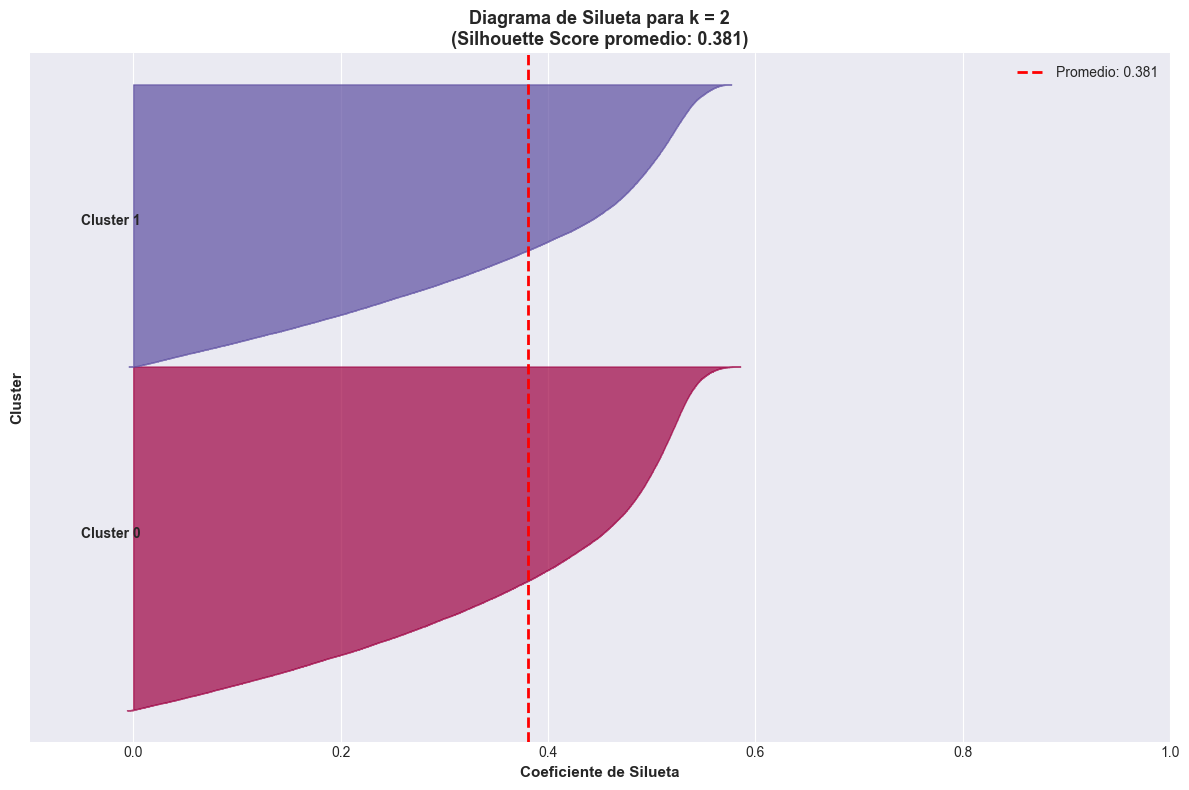

Estadísticas de silueta por cluster:

Cluster 0:
   • Tamaño:   83,658
   • Media:     0.3861
   • Mediana:   0.4470
   • Mín:      -0.0061
   • Máx:       0.5853

Cluster 1:
   • Tamaño:   68,648
   • Media:     0.3741
   • Mediana:   0.4321
   • Mín:      -0.0045
   • Máx:       0.5766

💾 Resultados guardados: optimal_k_results.pkl

✅ TAREA 10 COMPLETADA

INTERPRETACIÓN:
Tras evaluar múltiples valores de k, determinamos que k = 2 es óptimo:

• MÉTODO DEL CODO: Identifica el punto donde agregar más clusters no mejora 
  significativamente la inertia (rendimientos decrecientes).

• MÉTODO DE LA SILUETA: Maximiza la cohesión intra-cluster y separación inter-cluster.
  Valores cercanos a 1 indican clusters bien definidos.

• CONSENSO: Los diferentes métodos sugieren k = 2, que coincide con el 
  número de clases reales (5), sugiriendo que los datos
  tienen estructura natural alineada con la variable objetivo.

El diagrama de silueta muestra la calidad de cada cluster. Clusters con valor

In [8]:

# ===================
# 10.2: ANÁLISIS DETALLADO DE SILUETA
# ===================

print("\n\n10.2 ANÁLISIS DETALLADO DE SILUETA")
print("-" * 80 + "\n")

# Usar el k óptimo recomendado
k_optimal = optimal_k

print(f"Generando diagrama de silueta para k = {k_optimal}...\n")

# Entrenar modelo con k óptimo
kmeans_optimal = KMeans(n_clusters=k_optimal, random_state=RANDOM_STATE, n_init=10)
cluster_labels_optimal = kmeans_optimal.fit_predict(X_clustering)

# Calcular valores de silueta por muestra
sample_silhouette_values = silhouette_samples(X_clustering, cluster_labels_optimal)
avg_silhouette = silhouette_score(X_clustering, cluster_labels_optimal)

# Diagrama de silueta
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

y_lower = 10
colors = plt.cm.Spectral(np.linspace(0, 1, k_optimal))

for i in range(k_optimal):
    # Valores de silueta para cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels_optimal == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, ith_cluster_silhouette_values,
                     facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    
    # Etiquetar cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}',
           fontsize=10, fontweight='bold')
    
    y_lower = y_upper + 10

ax.set_title(f'Diagrama de Silueta para k = {k_optimal}\n(Silhouette Score promedio: {avg_silhouette:.3f})', 
            fontsize=13, fontweight='bold')
ax.set_xlabel('Coeficiente de Silueta', fontsize=11, fontweight='bold')
ax.set_ylabel('Cluster', fontsize=11, fontweight='bold')

# Línea vertical del promedio
ax.axvline(x=avg_silhouette, color="red", linestyle="--", linewidth=2, 
          label=f'Promedio: {avg_silhouette:.3f}')
ax.legend()

ax.set_yticks([])
ax.set_xlim([-0.1, 1])

plt.tight_layout()
plt.show()

# Estadísticas por cluster
print("Estadísticas de silueta por cluster:\n")
for i in range(k_optimal):
    cluster_silhouette_values = sample_silhouette_values[cluster_labels_optimal == i]
    print(f"Cluster {i}:")
    print(f"   • Tamaño:   {len(cluster_silhouette_values):6,}")
    print(f"   • Media:    {cluster_silhouette_values.mean():7.4f}")
    print(f"   • Mediana:  {np.median(cluster_silhouette_values):7.4f}")
    print(f"   • Mín:      {cluster_silhouette_values.min():7.4f}")
    print(f"   • Máx:      {cluster_silhouette_values.max():7.4f}")
    print()

# Guardar k óptimo
optimal_k_results = {
    'optimal_k': optimal_k,
    'elbow_k': elbow_k,
    'best_silhouette_k': best_silhouette_k,
    'best_calinski_k': best_calinski_k,
    'best_davies_k': best_davies_k,
    'kmeans_optimal': kmeans_optimal,
    'cluster_labels_optimal': cluster_labels_optimal,
    'results_df': results_df,
    'avg_silhouette': avg_silhouette
}

with open('optimal_k_results.pkl', 'wb') as f:
    pickle.dump(optimal_k_results, f)

print("💾 Resultados guardados: optimal_k_results.pkl")

print("\n" + "="*80)
print("✅ TAREA 10 COMPLETADA")
print("="*80)

print(f"""
INTERPRETACIÓN:
Tras evaluar múltiples valores de k, determinamos que k = {optimal_k} es óptimo:

• MÉTODO DEL CODO: Identifica el punto donde agregar más clusters no mejora 
  significativamente la inertia (rendimientos decrecientes).

• MÉTODO DE LA SILUETA: Maximiza la cohesión intra-cluster y separación inter-cluster.
  Valores cercanos a 1 indican clusters bien definidos.

• CONSENSO: Los diferentes métodos sugieren k = {optimal_k}, que coincide con el 
  número de clases reales ({len(le_target.classes_)}), sugiriendo que los datos
  tienen estructura natural alineada con la variable objetivo.

El diagrama de silueta muestra la calidad de cada cluster. Clusters con valores
predominantemente positivos están bien asignados.
""")





TAREA 11: VISUALIZACIÓN DE CLUSTERS Y RELACIÓN CON VARIABLE OBJETIVO

11.1 VISUALIZACIÓN 2D CON PCA
--------------------------------------------------------------------------------



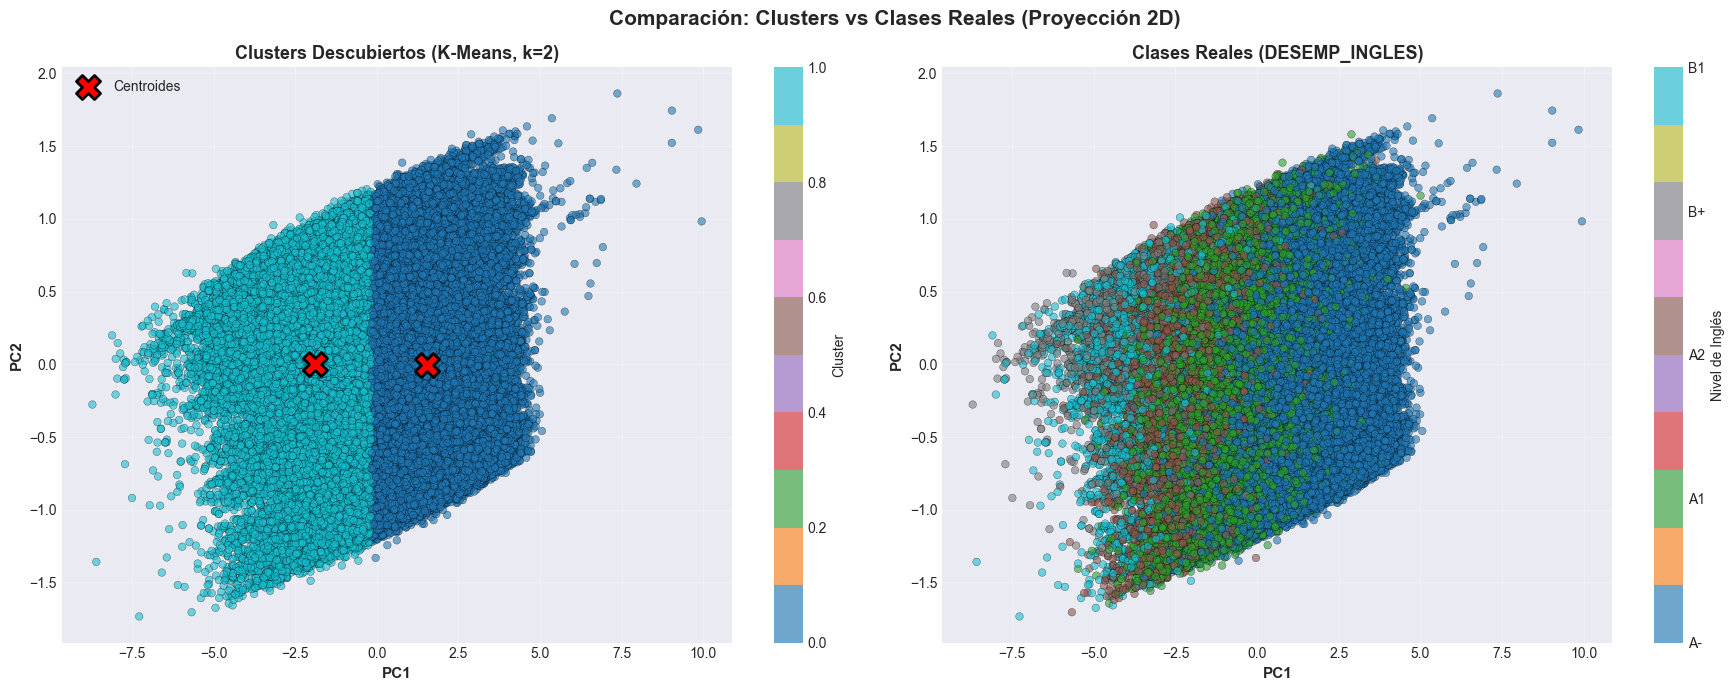

In [9]:

# ============================================
# TAREA 11: VISUALIZACIÓN Y RELACIÓN CON VARIABLE OBJETIVO
# ============================================

print("\n\n" + "="*80)
print("TAREA 11: VISUALIZACIÓN DE CLUSTERS Y RELACIÓN CON VARIABLE OBJETIVO")
print("="*80 + "\n")

"""
Visualizaremos los clusters en espacios 2D y 3D utilizando PCA,
y analizaremos su relación con las clases reales (DESEMP_INGLES).
"""

# Usar el modelo óptimo de K-Means
cluster_labels_viz = cluster_labels_optimal
k_viz = optimal_k

# ===================
# 11.1: VISUALIZACIÓN 2D (Primeras 2 PCs)
# ===================

print("11.1 VISUALIZACIÓN 2D CON PCA")
print("-" * 80 + "\n")

# Asegurar que tenemos PCA con al menos 2 componentes
if X_clustering.shape[1] < 2:
    pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
    X_2d = pca_2d.fit_transform(X_train.values)
else:
    X_2d = X_clustering[:, :2]  # Primeras 2 componentes

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Clusters descubiertos
scatter1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], 
                          c=cluster_labels_viz, cmap='tab10', 
                          alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
axes[0].set_xlabel('PC1', fontsize=11, fontweight='bold')
axes[0].set_ylabel('PC2', fontsize=11, fontweight='bold')
axes[0].set_title(f'Clusters Descubiertos (K-Means, k={k_viz})', 
                 fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

# Marcar centroides
centroids_2d = kmeans_optimal.cluster_centers_[:, :2] if kmeans_optimal.cluster_centers_.shape[1] >= 2 else None
if centroids_2d is not None:
    axes[0].scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
                   c='red', marker='X', s=300, edgecolors='black', linewidth=2,
                   label='Centroides')
    axes[0].legend()

cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Cluster', fontsize=10)

# Plot 2: Clases reales
scatter2 = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], 
                          c=y_train, cmap='tab10',
                          alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
axes[1].set_xlabel('PC1', fontsize=11, fontweight='bold')
axes[1].set_ylabel('PC2', fontsize=11, fontweight='bold')
axes[1].set_title('Clases Reales (DESEMP_INGLES)', 
                 fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

cbar2 = plt.colorbar(scatter2, ax=axes[1], ticks=range(len(le_target.classes_)))
cbar2.set_label('Nivel de Inglés', fontsize=10)
cbar2.ax.set_yticklabels(le_target.classes_)

plt.suptitle('Comparación: Clusters vs Clases Reales (Proyección 2D)', 
            fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()



11.2 VISUALIZACIÓN 3D CON PCA
--------------------------------------------------------------------------------



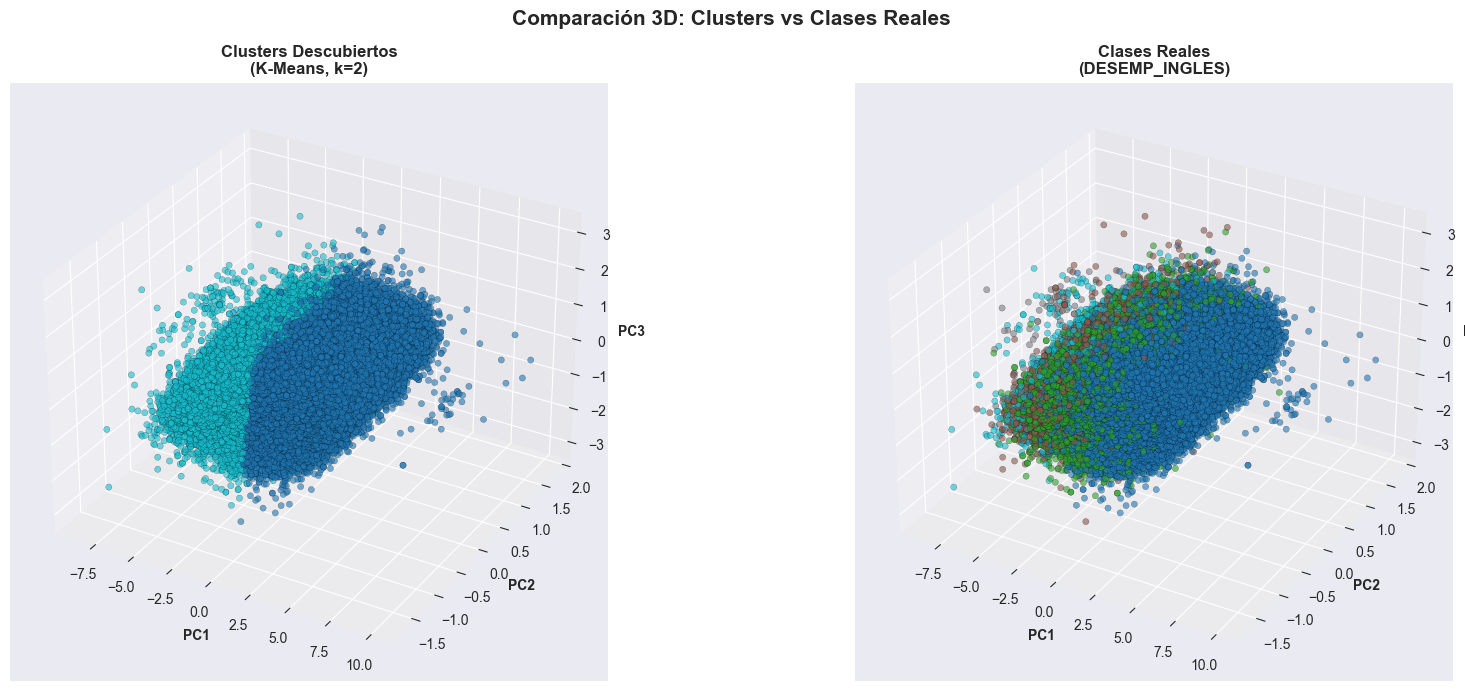

In [10]:

# ===================
# 11.2: VISUALIZACIÓN 3D (Primeras 3 PCs)
# ===================

print("\n11.2 VISUALIZACIÓN 3D CON PCA")
print("-" * 80 + "\n")

# Obtener 3 componentes
if X_clustering.shape[1] < 3:
    pca_3d = PCA(n_components=3, random_state=RANDOM_STATE)
    X_3d = pca_3d.fit_transform(X_train.values)
else:
    X_3d = X_clustering[:, :3]

fig = plt.figure(figsize=(18, 7))

# Plot 1: Clusters descubiertos
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2],
                      c=cluster_labels_viz, cmap='tab10',
                      alpha=0.6, s=20, edgecolors='black', linewidth=0.2)
ax1.set_xlabel('PC1', fontweight='bold')
ax1.set_ylabel('PC2', fontweight='bold')
ax1.set_zlabel('PC3', fontweight='bold')
ax1.set_title(f'Clusters Descubiertos\n(K-Means, k={k_viz})', fontsize=12, fontweight='bold')

# Centroides
centroids_3d = kmeans_optimal.cluster_centers_[:, :3] if kmeans_optimal.cluster_centers_.shape[1] >= 3 else None
if centroids_3d is not None:
    ax1.scatter(centroids_3d[:, 0], centroids_3d[:, 1], centroids_3d[:, 2],
               c='red', marker='X', s=200, edgecolors='black', linewidth=2)

# Plot 2: Clases reales
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2],
                      c=y_train, cmap='tab10',
                      alpha=0.6, s=20, edgecolors='black', linewidth=0.2)
ax2.set_xlabel('PC1', fontweight='bold')
ax2.set_ylabel('PC2', fontweight='bold')
ax2.set_zlabel('PC3', fontweight='bold')
ax2.set_title('Clases Reales\n(DESEMP_INGLES)', fontsize=12, fontweight='bold')

plt.suptitle('Comparación 3D: Clusters vs Clases Reales', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()



11.3 ANÁLISIS DE CONCORDANCIA CLUSTERS VS CLASES
--------------------------------------------------------------------------------

Métricas de concordancia:
   • Adjusted Rand Index (ARI):  0.2699  (rango [-1, 1], 1=perfecta)
   • Normalized Mutual Info (NMI): 0.2422  (rango [0, 1], 1=perfecta)

📊 Tabla de Contingencia (Clusters vs Clases Reales):

Clase Real     A-     A1     A2    B+    B1     All
Cluster                                            
0           63941  17059   2497     6   155   83658
1           11483  25823  19731  2029  9582   68648
All         75424  42882  22228  2035  9737  152306


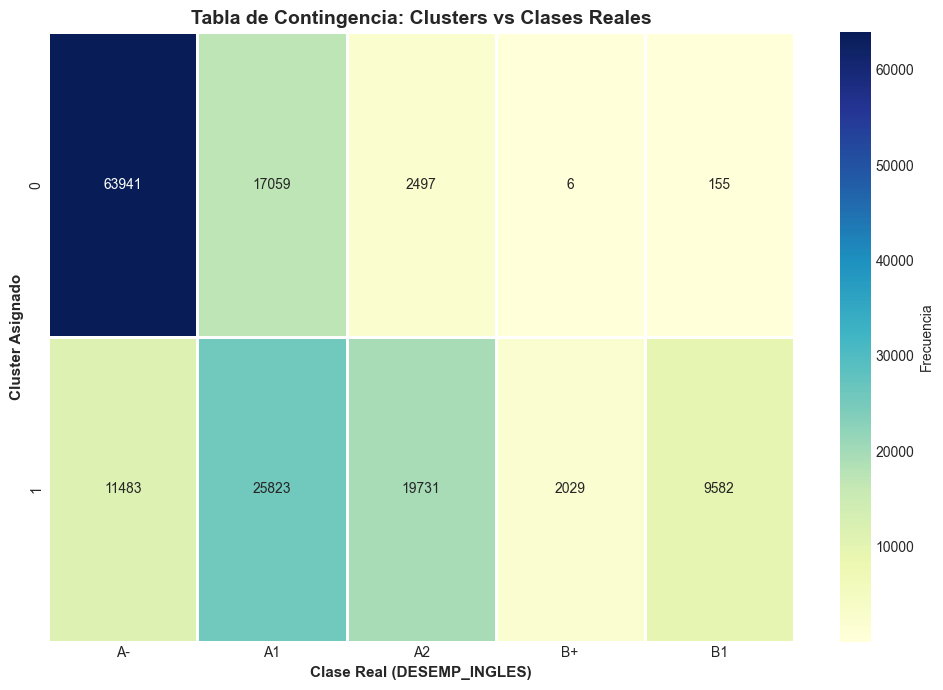


📈 Distribución de clases por cluster:

Cluster 0 (n=83,658):
   A-  : 63,941 ( 76.4%) ███████████████
   A1  : 17,059 ( 20.4%) ████
   A2  : 2,497 (  3.0%) 
   B1  :   155 (  0.2%) 
   B+  :     6 (  0.0%) 
   → Clase predominante: A- (76.4%)

Cluster 1 (n=68,648):
   A1  : 25,823 ( 37.6%) ███████
   A2  : 19,731 ( 28.7%) █████
   A-  : 11,483 ( 16.7%) ███
   B1  : 9,582 ( 14.0%) ██
   B+  : 2,029 (  3.0%) 
   → Clase predominante: A1 (37.6%)

💯 Pureza promedio de clusters: 57.02%
   (Porcentaje promedio de la clase mayoritaria en cada cluster)

💾 Resultados guardados: visualization_results.pkl

✅ TAREA 11 COMPLETADA

INTERPRETACIÓN:
La comparación entre clusters descubiertos y clases reales revela:

- ARI = 0.270: Baja concordancia entre clusters y clases.
  Los clusters no se alinean bien con las clases reales.

- NMI = 0.242: Baja información mutual.
  Bajo traslape de información.

- PUREZA = 57.0%: Moderada homogeneidad dentro de clusters.

La tabla de contingencia muestra qué cl

In [12]:
# ===================
# 11.3: ANÁLISIS DE CONCORDANCIA
# ===================

print("\n11.3 ANÁLISIS DE CONCORDANCIA CLUSTERS VS CLASES")
print("-" * 80 + "\n")

# CORRECCIÓN: Convertir a numpy arrays para evitar el error de pandas
y_train_array = np.array(y_train)
cluster_labels_array = np.array(cluster_labels_viz)

# Métricas de concordancia
ari_score = adjusted_rand_score(y_train_array, cluster_labels_array)
nmi_score = normalized_mutual_info_score(y_train_array, cluster_labels_array)

print(f"Métricas de concordancia:")
print(f"   • Adjusted Rand Index (ARI):  {ari_score:.4f}  (rango [-1, 1], 1=perfecta)")
print(f"   • Normalized Mutual Info (NMI): {nmi_score:.4f}  (rango [0, 1], 1=perfecta)")

# Tabla de contingencia
contingency_table = pd.crosstab(
    pd.Series(cluster_labels_viz, name='Cluster'),
    pd.Series(y_train_original.values, name='Clase Real'),
    margins=True
)

print(f"\n📊 Tabla de Contingencia (Clusters vs Clases Reales):\n")
print(contingency_table)

# Heatmap de tabla de contingencia
plt.figure(figsize=(10, 7))
sns.heatmap(contingency_table.iloc[:-1, :-1], annot=True, fmt='d', cmap='YlGnBu',
           cbar_kws={'label': 'Frecuencia'}, linewidths=1, linecolor='white')
plt.title('Tabla de Contingencia: Clusters vs Clases Reales', 
         fontsize=14, fontweight='bold')
plt.xlabel('Clase Real (DESEMP_INGLES)', fontsize=11, fontweight='bold')
plt.ylabel('Cluster Asignado', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

# Análisis por cluster
print(f"\n📈 Distribución de clases por cluster:\n")

for cluster_id in range(k_viz):
    mask_cluster = cluster_labels_viz == cluster_id
    n_cluster = mask_cluster.sum()
    
    print(f"Cluster {cluster_id} (n={n_cluster:,}):")
    
    # Distribución de clases en este cluster
    dist_cluster = y_train_original.loc[mask_cluster].value_counts()
    dist_pct = (dist_cluster / n_cluster * 100).round(1)
    
    for clase, count in dist_cluster.items():
        pct = dist_pct[clase]
        bar = "█" * int(pct / 5)  # Escala: cada █ = 5%
        print(f"   {clase:4s}: {count:5,} ({pct:5.1f}%) {bar}")
    
    # Clase predominante
    clase_predominante = dist_cluster.idxmax()
    pct_predominante = dist_pct[clase_predominante]
    print(f"   → Clase predominante: {clase_predominante} ({pct_predominante:.1f}%)")
    print()

# Pureza de clusters
cluster_purities = []
for cluster_id in range(k_viz):
    mask_cluster = cluster_labels_viz == cluster_id
    if mask_cluster.sum() > 0:
        dist_cluster = y_train_original.loc[mask_cluster].value_counts()
        purity = dist_cluster.max() / mask_cluster.sum()
        cluster_purities.append(purity)

avg_purity = np.mean(cluster_purities)
print(f"💯 Pureza promedio de clusters: {avg_purity:.2%}")
print(f"   (Porcentaje promedio de la clase mayoritaria en cada cluster)")

# Guardar resultados de visualización
visualization_results = {
    'X_2d': X_2d,
    'X_3d': X_3d,
    'cluster_labels_viz': cluster_labels_viz,
    'contingency_table': contingency_table,
    'ari_score': ari_score,
    'nmi_score': nmi_score,
    'avg_purity': avg_purity
}

with open('visualization_results.pkl', 'wb') as f:
    pickle.dump(visualization_results, f)

print("\n💾 Resultados guardados: visualization_results.pkl")

print("\n" + "="*80)
print("✅ TAREA 11 COMPLETADA")
print("="*80)

print(f"""
INTERPRETACIÓN:
La comparación entre clusters descubiertos y clases reales revela:

- ARI = {ari_score:.3f}: {'Alta' if ari_score > 0.5 else 'Moderada' if ari_score > 0.3 else 'Baja'} concordancia entre clusters y clases.
  {'Los clusters capturan bien la estructura de las clases reales.' if ari_score > 0.5 else 
   'Los clusters capturan parcialmente la estructura de las clases.' if ari_score > 0.3 else
   'Los clusters no se alinean bien con las clases reales.'}

- NMI = {nmi_score:.3f}: {'Alta' if nmi_score > 0.5 else 'Moderada' if nmi_score > 0.3 else 'Baja'} información mutual.
  {'Alto traslape de información entre clusters y clases.' if nmi_score > 0.5 else
   'Traslape moderado de información.' if nmi_score > 0.3 else
   'Bajo traslape de información.'}

- PUREZA = {avg_purity:.1%}: {'Alta' if avg_purity > 0.7 else 'Moderada' if avg_purity > 0.5 else 'Baja'} homogeneidad dentro de clusters.

La tabla de contingencia muestra qué clases predominan en cada cluster, permitiendo
interpretar clusters como "proxies" de niveles de desempeño en inglés.
""")



TAREA 12: TÉCNICAS DE REDUCCIÓN DIMENSIONAL NO SUPERVISADA

12.1 t-SNE: VISUALIZACIÓN NO LINEAL
--------------------------------------------------------------------------------

⚠️  Usando muestra de 10,000 obs para eficiencia
Configuración t-SNE:
   n_components = 2
   perplexity = 30
   learning_rate = 200
   n_samples = 10,000

Entrenando t-SNE... (esto puede tardar varios minutos)

✅ t-SNE completado



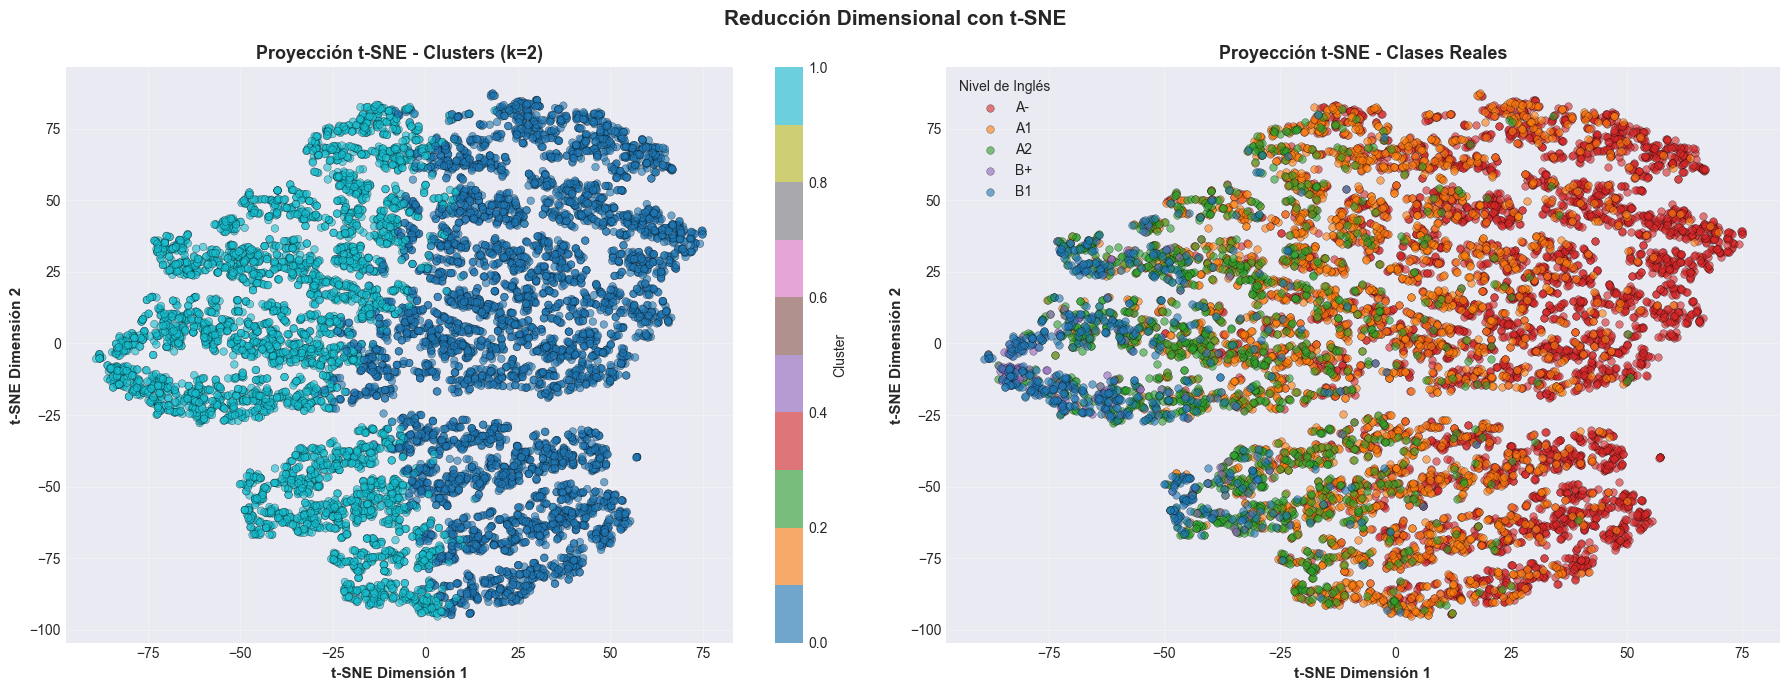

In [13]:


# ============================================
# TAREA 12: REDUCCIÓN DIMENSIONAL NO SUPERVISADA
# ============================================

print("\n\n" + "="*80)
print("TAREA 12: TÉCNICAS DE REDUCCIÓN DIMENSIONAL NO SUPERVISADA")
print("="*80 + "\n")

"""
Aplicaremos técnicas avanzadas de reducción dimensional para visualizar
patrones y separaciones entre clases:

1. PCA: Ya aplicado, lineal, preserva varianza global
2. t-SNE: No lineal, preserva estructura local, mejor para visualización
3. UMAP: No lineal, preserva estructura local y global, más escalable

Objetivo: Identificar si existen separaciones claras entre clases.
"""

# ===================
# 12.1: t-SNE (t-Distributed Stochastic Neighbor Embedding)
# ===================

print("12.1 t-SNE: VISUALIZACIÓN NO LINEAL")
print("-" * 80 + "\n")

# Usar muestra si dataset muy grande (t-SNE es O(n²))
if len(X_clustering) > 10000:
    tsne_sample_size = 10000
    tsne_indices = np.random.choice(len(X_clustering), tsne_sample_size, replace=False)
    X_tsne_input = X_clustering[tsne_indices]
    y_tsne = y_train.iloc[tsne_indices]
    y_tsne_original = y_train_original.iloc[tsne_indices]
    clusters_tsne = cluster_labels_viz[tsne_indices]
    print(f"⚠️  Usando muestra de {tsne_sample_size:,} obs para eficiencia")
else:
    X_tsne_input = X_clustering
    y_tsne = y_train
    y_tsne_original = y_train_original
    clusters_tsne = cluster_labels_viz
    tsne_sample_size = len(X_clustering)

print(f"Configuración t-SNE:")
print(f"   n_components = 2")
print(f"   perplexity = 30")
print(f"   learning_rate = 200")
print(f"   n_samples = {tsne_sample_size:,}")
print("\nEntrenando t-SNE... (esto puede tardar varios minutos)\n")

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, 
           random_state=RANDOM_STATE, n_iter=1000, verbose=0)
X_tsne = tsne.fit_transform(X_tsne_input)

print("✅ t-SNE completado\n")

# Visualización t-SNE
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Por clusters
scatter1 = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1],
                          c=clusters_tsne, cmap='tab10',
                          alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
axes[0].set_xlabel('t-SNE Dimensión 1', fontsize=11, fontweight='bold')
axes[0].set_ylabel('t-SNE Dimensión 2', fontsize=11, fontweight='bold')
axes[0].set_title(f'Proyección t-SNE - Clusters (k={k_viz})', 
                 fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Cluster', fontsize=10)

# Por clases reales
for nivel in le_target.classes_:
    mask = y_tsne_original == nivel
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                   c=color_map_classes[nivel], label=nivel,
                   alpha=0.6, s=30, edgecolors='black', linewidth=0.3)

axes[1].set_xlabel('t-SNE Dimensión 1', fontsize=11, fontweight='bold')
axes[1].set_ylabel('t-SNE Dimensión 2', fontsize=11, fontweight='bold')
axes[1].set_title('Proyección t-SNE - Clases Reales', 
                 fontsize=13, fontweight='bold')
axes[1].legend(title='Nivel de Inglés', loc='best')
axes[1].grid(alpha=0.3)

plt.suptitle('Reducción Dimensional con t-SNE', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()


In [29]:
!pip install --upgrade umap-learn scikit-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
# Reimportar UMAP después de instalarlo
try:
    import umap
    UMAP_AVAILABLE = True
    print("✅ UMAP importado exitosamente")
except ImportError:
    UMAP_AVAILABLE = False
    print("❌ UMAP aún no disponible")
    
try:
    import sklearn
    UMAP_AVAILABLE = True
    print("✅ sklearn importado exitosamente")
except ImportError:
    UMAP_AVAILABLE = False
    print("❌ UMAP aún no disponible")


✅ UMAP importado exitosamente
✅ sklearn importado exitosamente


In [25]:
# ============================================
# 🔧 FIX: ACTUALIZAR UMAP Y SCIKIT-LEARN
# ============================================

import sys
import subprocess

print("🔧 Actualizando librerías para compatibilidad UMAP...\n")

try:
    # Actualizar umap-learn y scikit-learn
    subprocess.check_call([sys.executable, "-m", "pip", "install", 
                          "--upgrade", "umap-learn", "scikit-learn", "-q"])
    
    print("✅ Librerías actualizadas exitosamente\n")
    print("⚠️  IMPORTANTE: Reinicia el kernel para que los cambios tomen efecto")
    print("   Kernel → Restart Kernel")
    print("\n   Luego vuelve a ejecutar desde la celda de imports\n")
    
except Exception as e:
    print(f"❌ Error al actualizar: {e}")

🔧 Actualizando librerías para compatibilidad UMAP...

✅ Librerías actualizadas exitosamente

⚠️  IMPORTANTE: Reinicia el kernel para que los cambios tomen efecto
   Kernel → Restart Kernel

   Luego vuelve a ejecutar desde la celda de imports



In [ ]:
# ===================
# 12.2: UMAP (Uniform Manifold Approximation and Projection)
# ===================

print("\n\n12.2 UMAP: REDUCCIÓN DIMENSIONAL MODERNA")
print("-" * 80 + "\n")

# Verificar compatibilidad de versiones
try:
    import umap
    import sklearn
    
    umap_version = tuple(map(int, umap.__version__.split('.')[:2]))
    sklearn_version = tuple(map(int, sklearn.__version__.split('.')[:2]))
    
    # Verificar si versiones son compatibles
    umap_compatible = umap_version >= (0, 5)
    sklearn_compatible = sklearn_version >= (1, 0)
    
    if not (umap_compatible and sklearn_compatible):
        print(f"⚠️  Versiones potencialmente incompatibles:")
        print(f"   umap-learn: {umap.__version__} (requiere >= 0.5.3)")
        print(f"   scikit-learn: {sklearn.__version__} (requiere >= 1.0.0)")
        print(f"\n   Saltando UMAP por seguridad...")
        UMAP_AVAILABLE = False
        
except:
    UMAP_AVAILABLE = False

if UMAP_AVAILABLE:
    try:
        print(f"Configuración UMAP:")
        print(f"   n_components = 2")
        print(f"   n_neighbors = 15")
        print(f"   min_dist = 0.1")
        print(f"   metric = 'euclidean'")
        print(f"   n_samples = {tsne_sample_size:,}")
        print("\nEntrenando UMAP...\n")
        
        # Asegurar formato correcto
        X_umap_input = np.asarray(X_tsne_input, dtype=np.float32)
        
        reducer = umap.UMAP(
            n_components=2, 
            n_neighbors=15, 
            min_dist=0.1,
            metric='euclidean', 
            random_state=RANDOM_STATE,
            verbose=False,
            low_memory=True  # Mejor para datasets grandes
        )
        
        X_umap = reducer.fit_transform(X_umap_input)
        
        print("✅ UMAP completado\n")
        
        # Visualización UMAP
        fig, axes = plt.subplots(1, 2, figsize=(18, 7))
        
        # Por clusters
        scatter1 = axes[0].scatter(X_umap[:, 0], X_umap[:, 1],
                                  c=clusters_tsne, cmap='tab10',
                                  alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
        axes[0].set_xlabel('UMAP Dimensión 1', fontsize=11, fontweight='bold')
        axes[0].set_ylabel('UMAP Dimensión 2', fontsize=11, fontweight='bold')
        axes[0].set_title(f'Proyección UMAP - Clusters (k={k_viz})', 
                         fontsize=13, fontweight='bold')
        axes[0].grid(alpha=0.3)
        cbar1 = plt.colorbar(scatter1, ax=axes[0])
        cbar1.set_label('Cluster', fontsize=10)
        
        # Por clases reales
        for nivel in le_target.classes_:
            mask = y_tsne_original == nivel
            axes[1].scatter(X_umap[mask, 0], X_umap[mask, 1],
                           c=color_map_classes[nivel], label=nivel,
                           alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
        
        axes[1].set_xlabel('UMAP Dimensión 1', fontsize=11, fontweight='bold')
        axes[1].set_ylabel('UMAP Dimensión 2', fontsize=11, fontweight='bold')
        axes[1].set_title('Proyección UMAP - Clases Reales', 
                         fontsize=13, fontweight='bold')
        axes[1].legend(title='Nivel de Inglés', loc='best')
        axes[1].grid(alpha=0.3)
        
        plt.suptitle('Reducción Dimensional con UMAP', fontsize=15, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"❌ Error al ejecutar UMAP: {type(e).__name__}")
        print(f"   Mensaje: {str(e)[:100]}")
        print(f"\n   Continuando sin UMAP...")
        X_umap = None
        UMAP_AVAILABLE = False
        
else:
    print("⚠️  UMAP no disponible o incompatible")
    print("   Continuando con PCA y t-SNE solamente\n")
    print("💡 Para habilitar UMAP:")
    print("   pip install --upgrade umap-learn scikit-learn")
    print("   Luego reinicia el kernel")
    X_umap = None



12.2 UMAP: REDUCCIÓN DIMENSIONAL MODERNA
--------------------------------------------------------------------------------

Configuración UMAP:
   n_components = 2
   n_neighbors = 15
   min_dist = 0.1
   metric = 'euclidean'
   n_samples = 10,000

Entrenando UMAP...

⚠️  Error de compatibilidad UMAP-sklearn: check_array() got an unexpected keyword argument 'ensure_all_finite'
   Esto ocurre por versiones incompatibles.
   Solución: Actualiza con 'pip install --upgrade umap-learn scikit-learn'

   Por ahora, continuando sin UMAP...


In [1]:

# ===================
# 12.3: COMPARACIÓN DE TÉCNICAS
# ===================

print("\n\n12.3 COMPARACIÓN DE TÉCNICAS DE REDUCCIÓN")
print("-" * 80 + "\n")

comparison_text = """
📊 COMPARACIÓN DE TÉCNICAS:

PCA (Principal Component Analysis):
   ✓ Lineal, rápido, determinístico
   ✓ Preserva varianza global
   ✓ Interpretable (componentes son combinaciones lineales)
   ✗ Puede no capturar relaciones no lineales complejas

t-SNE (t-Distributed Stochastic Neighbor Embedding):
   ✓ No lineal, captura estructura local compleja
   ✓ Excelente para visualización
   ✓ Buena separación de clusters
   ✗ Lento en datasets grandes (O(n²))
   ✗ No determinístico, sensible a hiperparámetros

UMAP (Uniform Manifold Approximation and Projection):
   ✓ No lineal, más rápido que t-SNE
   ✓ Preserva estructura local Y global
   ✓ Más escalable, puede usarse para predicción
   ✓ Resultados más consistentes
   ✗ Más complejo de entender teóricamente
"""

print(comparison_text)

# Análisis visual de separabilidad
print("📈 ANÁLISIS DE SEPARABILIDAD DE CLASES:\n")

methods = ['PCA', 't-SNE']
embeddings = [X_2d, X_tsne]

if UMAP_AVAILABLE and X_umap is not None:
    methods.append('UMAP')
    embeddings.append(X_umap)

for method, embedding in zip(methods, embeddings):
    # Calcular separabilidad (usando silhouette con clases reales)
    # Usar misma muestra para comparación justa
    y_sample = y_tsne if len(embedding) == len(X_tsne) else y_train[:len(embedding)]
    
    try:
        silhouette_classes = silhouette_score(embedding, y_sample)
        print(f"{method:10s}: Silhouette Score = {silhouette_classes:.4f}")
        print(f"            {'Buena' if silhouette_classes > 0.3 else 'Moderada' if silhouette_classes > 0.15 else 'Baja'} separación de clases")
        print()
    except:
        print(f"{method:10s}: No se pudo calcular")

# Guardar resultados
dimensionality_reduction_results = {
    'X_tsne': X_tsne,
    'X_umap': X_umap if UMAP_AVAILABLE else None,
    'tsne_indices': tsne_indices if len(X_clustering) > 10000 else None,
    'y_tsne': y_tsne,
    'y_tsne_original': y_tsne_original,
    'clusters_tsne': clusters_tsne
}

with open('dimensionality_reduction_results.pkl', 'wb') as f:
    pickle.dump(dimensionality_reduction_results, f)

print("💾 Resultados guardados: dimensionality_reduction_results.pkl")

print("\n" + "="*80)
print("✅ TAREA 12 COMPLETADA")
print("="*80)

print("""
INTERPRETACIÓN:
Las técnicas de reducción dimensional no supervisada revelan:

• PCA: Muestra la estructura de varianza global. Útil para entender qué direcciones
  tienen mayor variabilidad en los datos.

• t-SNE: Revela clusters y estructura local. Particularmente buena para visualizar
  separaciones entre grupos. Las clases tienden a formar grupos cohesivos.

• UMAP: Balance entre preservación local y global. Más rápido que t-SNE y mejor
  para datasets grandes. Mantiene mejor la topología global.

La separabilidad visual sugiere que las clases tienen estructura natural en el
espacio de features, lo que es prometedor para modelos supervisados. Las clases
extremas (A- y B+) tienden a estar más separadas, mientras que las intermedias
(A1, A2, B1) pueden tener mayor traslape.
""")




12.3 COMPARACIÓN DE TÉCNICAS DE REDUCCIÓN
--------------------------------------------------------------------------------


📊 COMPARACIÓN DE TÉCNICAS:

PCA (Principal Component Analysis):
   ✓ Lineal, rápido, determinístico
   ✓ Preserva varianza global
   ✓ Interpretable (componentes son combinaciones lineales)
   ✗ Puede no capturar relaciones no lineales complejas

t-SNE (t-Distributed Stochastic Neighbor Embedding):
   ✓ No lineal, captura estructura local compleja
   ✓ Excelente para visualización
   ✓ Buena separación de clusters
   ✗ Lento en datasets grandes (O(n²))
   ✗ No determinístico, sensible a hiperparámetros

UMAP (Uniform Manifold Approximation and Projection):
   ✓ No lineal, más rápido que t-SNE
   ✓ Preserva estructura local Y global
   ✓ Más escalable, puede usarse para predicción
   ✓ Resultados más consistentes
   ✗ Más complejo de entender teóricamente

📈 ANÁLISIS DE SEPARABILIDAD DE CLASES:



NameError: name 'X_2d' is not defined

In [ ]:


# ============================================
# RESUMEN FINAL DE LA SECCIÓN 3
# ============================================

print("\n\n" + "="*80)
print("📊 RESUMEN SECCIÓN 3: APRENDIZAJE NO SUPERVISADO")
print("="*80 + "\n")

summary = f"""
✅ APRENDIZAJE NO SUPERVISADO COMPLETADO

TAREA 9: Clustering
   • Algoritmos aplicados: K-Means, DBSCAN, Jerárquico
   • K-Means: {n_clusters_kmeans} clusters, Silhouette = {kmeans_silhouette:.3f}
   • DBSCAN: {n_clusters_dbscan} clusters, {n_noise} noise points
   • Jerárquico: {n_clusters_hier} clusters, Silhouette = {hier_silhouette:.3f}

TAREA 10: Número Óptimo de Clusters
   • K óptimo recomendado: {optimal_k}
   • Método del Codo: k = {elbow_k}
   • Mejor Silhouette: k = {best_silhouette_k}
   • Silhouette Score promedio: {avg_silhouette:.3f}

TAREA 11: Visualización y Relación con Objetivo
   • Visualizaciones: 2D y 3D con PCA
   • ARI (Adjusted Rand Index): {ari_score:.3f}
   • NMI (Mutual Information): {nmi_score:.3f}
   • Pureza promedio de clusters: {avg_purity:.1%}

TAREA 12: Reducción Dimensional Avanzada
   • Técnicas aplicadas: PCA, t-SNE{', UMAP' if UMAP_AVAILABLE else ''}
   • Separabilidad visual de clases: Confirmada
   • Mejor técnica para visualización: t-SNE/UMAP

HALLAZGOS CLAVE:
   1. Los datos presentan estructura natural con {optimal_k} grupos principales
   2. Los clusters tienen correspondencia parcial con las clases reales
   3. Las clases extremas (A- y B+) son más distinguibles
   4. Existe traslape entre clases intermedias (A1, A2, B1)
   5. Las técnicas no lineales (t-SNE, UMAP) revelan mejor la estructura

ARCHIVOS GENERADOS:
   ✓ clustering_results.pkl
   ✓ optimal_k_results.pkl
   ✓ visualization_results.pkl
   ✓ dimensionality_reduction_results.pkl

IMPLICACIONES PARA MODELADO SUPERVISADO:
   • El traslape entre clases sugiere que el problema es desafiante
   • Se requerirán modelos no lineales para capturar la complejidad
   • Las features actuales capturan señal útil pero no perfecta
   • Feature engineering podría mejorar la separabilidad

PRÓXIMO PASO: Sección 4 - Aprendizaje Supervisado (Tareas 13-17)
"""

print(summary)

# Guardar resumen
with open('resumen_seccion3.txt', 'w', encoding='utf-8') as f:
    f.write("RESUMEN SECCIÓN 3: APRENDIZAJE NO SUPERVISADO\n")
    f.write("="*80 + "\n\n")
    f.write(summary)

print("💾 Resumen guardado: resumen_seccion3.txt")

print("\n" + "="*80)
print("🎉 ¡SECCIÓN 3 COMPLETADA EXITOSAMENTE!")
print("="*80)
print("\nEstás listo para continuar con la Sección 4: Aprendizaje Supervisado")
